Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                             

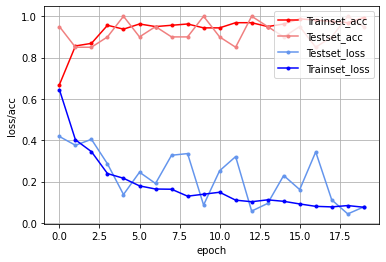

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.applications import VGG16

np.random.seed(3)
tf.random.set_seed(3)



train_datagen = ImageDataGenerator(rescale=1./255, #이미지의 색은 0~255의 RGB값을 가지기때문에 255로나누어 0~1사이의 값으로
                                   horizontal_flip=True,# 수평 대칭 이미지를 50% 확률로 만들어 추가
                                   width_shift_range=0.1, #전체 크기의 10%범위에서 좌우로 이동
                                   height_shift_range=0.1, #전체 크기의 10%범위에서 상하로 이동
                                   fill_mode='nearest') 


train_generator = train_datagen.flow_from_directory('./train', #이미지가 위치한 폴더 위치
                                                    target_size=(150, 150), #이미지 크기
                                                    batch_size=5,
                                                    class_mode='binary') # 치매/정상 2진 분류이므로 바이너리 모드로 실행

test_datagen = ImageDataGenerator(rescale = 1./255)



test_generator = test_datagen.flow_from_directory('./test',
                                                  target_size = (150, 150),
                                                  batch_size = 5,
                                                  class_mode = 'binary')

"""
전의 학습과 차이점은 이 부분이다
VGG16이라는 이미지 처리 대회에서 우승한 머신러닝 층을 그대로 이용하는 전이 학습(tranfer_learning)을 한 후
추가적으로 층을 추가하여 미세 조정을 한 후 학습을 시킨 방식이다.
이와 같이 이미지 처리의 경우 이미 완성된 층을 이용하는 방식이 더 높은 학습률을 보인다.
"""
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()
finetune_model = Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

history = finetune_model.fit(train_generator, #train_generator를 학습 모델로 사용
                    steps_per_epoch=32, #이미지 생성기에서 몇개의 샘플을 뽑을지 결정
                    epochs=20, 
                    validation_data=test_generator, #앞서 만들어진 test_generator를 테스트셋으로 사용
                    validation_steps=4)

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()